In [0]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, concatenate, Conv2DTranspose, BatchNormalization, Activation, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Functions

In [0]:
def rotate(img):
    if img.height < img.width:
        img = img.rotate(-90, expand=1)
    return img

In [0]:
def frame(img):

  npimg = np.asarray(img)

  lower = [250,250,250]
  upper = [255,255,255]

  # create NumPy arrays from the boundaries
  lower = np.array(lower, dtype="uint8")
  upper = np.array(upper, dtype="uint8")

  #create a frame as a mask
  mask = cv2.inRange(npimg, lower, upper)
  mask = cv2.threshold(mask,127,255,cv2.THRESH_BINARY)[1]

  x, y, w, h = cv2.boundingRect(mask) 
  for i in range(y+10, y+h-10):
    for j in range(x+10, x+w-10):
        mask[i,j] = 255

  res = cv2.bitwise_and(npimg,npimg,mask = mask)

  return res

In [0]:
def dataset_normalized(imgs):
    imgs_normalized = np.empty(imgs.shape)
    imgs_std = np.std(imgs)
    imgs_mean = np.mean(imgs)
    imgs_normalized = (imgs-imgs_mean)/imgs_std
    for i in range(imgs.shape[0]):
        imgs_normalized[i] = ((imgs_normalized[i] - np.min(imgs_normalized[i])) / (np.max(imgs_normalized[i])-np.min(imgs_normalized[i])))*255
    return imgs_normalized

In [0]:
def clahe_equalized(imgs):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    imgs_equalized = np.empty(imgs.shape)
    for i in range(imgs.shape[0]):
        R, G, B = cv2.split(imgs[i])

        output1_R = clahe.apply(np.array(R, dtype = np.uint8))
        output1_G = clahe.apply(np.array(G, dtype = np.uint8))
        output1_B = clahe.apply(np.array(B, dtype = np.uint8))

        equ = cv2.merge((output1_R, output1_G, output1_B))
        imgs_equalized[i] = equ
    return imgs_equalized

### Uploading images

In [0]:
data_path = '/content/drive/My Drive/Colab Notebooks/Wheat Dataset/'
mask_path = '/content/drive/My Drive/Colab Notebooks/Masks/'

In [0]:
height = 756
width  = 756
channels = 3

wheat_dataset = np.zeros([62, height, width, channels])
wheat_dataset_mask = np.zeros([62, height, width])

In [0]:
data_names = [item for item in os.listdir(data_path)]

In [0]:
ind = 0
for image in data_names:
  img_path = data_path + image
  img_mask_path = mask_path + image[0:len(image)-4] +'_mask.png'

  img = Image.open(img_path, mode='r')
  img = rotate(img)
  img = img.resize([height, width], resample=PIL.Image.BILINEAR)

  mask = Image.open(img_mask_path, mode='r').convert('L')
  mask = rotate(mask)
  mask = mask.resize([height, width], resample=PIL.Image.BILINEAR)

  img = frame(img)
  wheat_dataset[ind, :, :, :] = img
  wheat_dataset_mask[ind, :, :] = mask

  ind += 1

In [0]:
tr_data = wheat_dataset[0:50,:,:,:]
te_data = wheat_dataset[50:62,:,:,:]

tr_mask = wheat_dataset_mask[0:50,:,:]
te_mask = wheat_dataset_mask[50:62,:,:]

In [0]:
tr_data   = dataset_normalized(tr_data)
te_data   = dataset_normalized(te_data)

tr_data   = clahe_equalized(tr_data)
te_data   = clahe_equalized(te_data)

tr_data   = tr_data/255.
te_data   = te_data/255.

In [0]:
tr_mask    = tr_mask/255.
te_mask    = te_mask/255.

In [0]:
tr_mask    = np.expand_dims(tr_mask, axis=3)
te_mask    = np.expand_dims(te_mask, axis=3)

In [0]:
input_size=(756, 756, 3)
inputs = Input(input_size)                                                                 

In [0]:
conv1 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
conv1 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
pool1 = MaxPool2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv2 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
pool2 = MaxPool2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv3 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
drop3 = Dropout(0.5)(conv3)
pool3 = MaxPool2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
conv4_1 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
drop4_1 = Dropout(0.5)(conv4_1)

conv4_2 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop4_1)
conv4_2 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4_2)
conv4_2 = Dropout(0.5)(conv4_2)
merge_dense = concatenate([conv4_2, drop4_1], axis=3)

conv4_3 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge_dense)
conv4_3 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4_3)
drop4_3 = Dropout(0.5)(conv4_3)

up6 = Conv2DTranspose(512, kernel_size=2, strides=2, padding='same', kernel_initializer='he_normal')(drop4_3)
up6 = BatchNormalization(axis=3)(up6)
up6 = Activation('relu')(up6)

conv4_3b = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up6)
conv4_3b = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4_3b)
drop4_3b = Dropout(0.5)(conv4_3b)

conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop4_3b)
conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

up7 = Conv2DTranspose(256, kernel_size=2, strides=2, padding='same', kernel_initializer='he_normal')(conv6)
up7 = BatchNormalization(axis=3)(up7)
up7 = Activation('relu')(up7)

conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up7)
conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
conv9 = Conv2D(1, 1, activation='sigmoid')(conv8)

model = Model(inputs=inputs, outputs=conv9)

In [0]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 756, 756, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 756, 756, 128 3584        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 756, 756, 128 147584      conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 378, 378, 128 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [0]:
model.fit(tr_data, tr_mask, batch_size=1,
                    epochs=5,
                    shuffle=True,
                    verbose=1)

Epoch 1/5
48/50 [===========================>..] - ETA: 11s - loss: 0.1731 - accuracy: 0.9373

In [0]:
predictions = model.predict(te_data, batch_size=2, verbose=1)

6/6 [==============================] - 24s 4s/step


IndexError: ignored

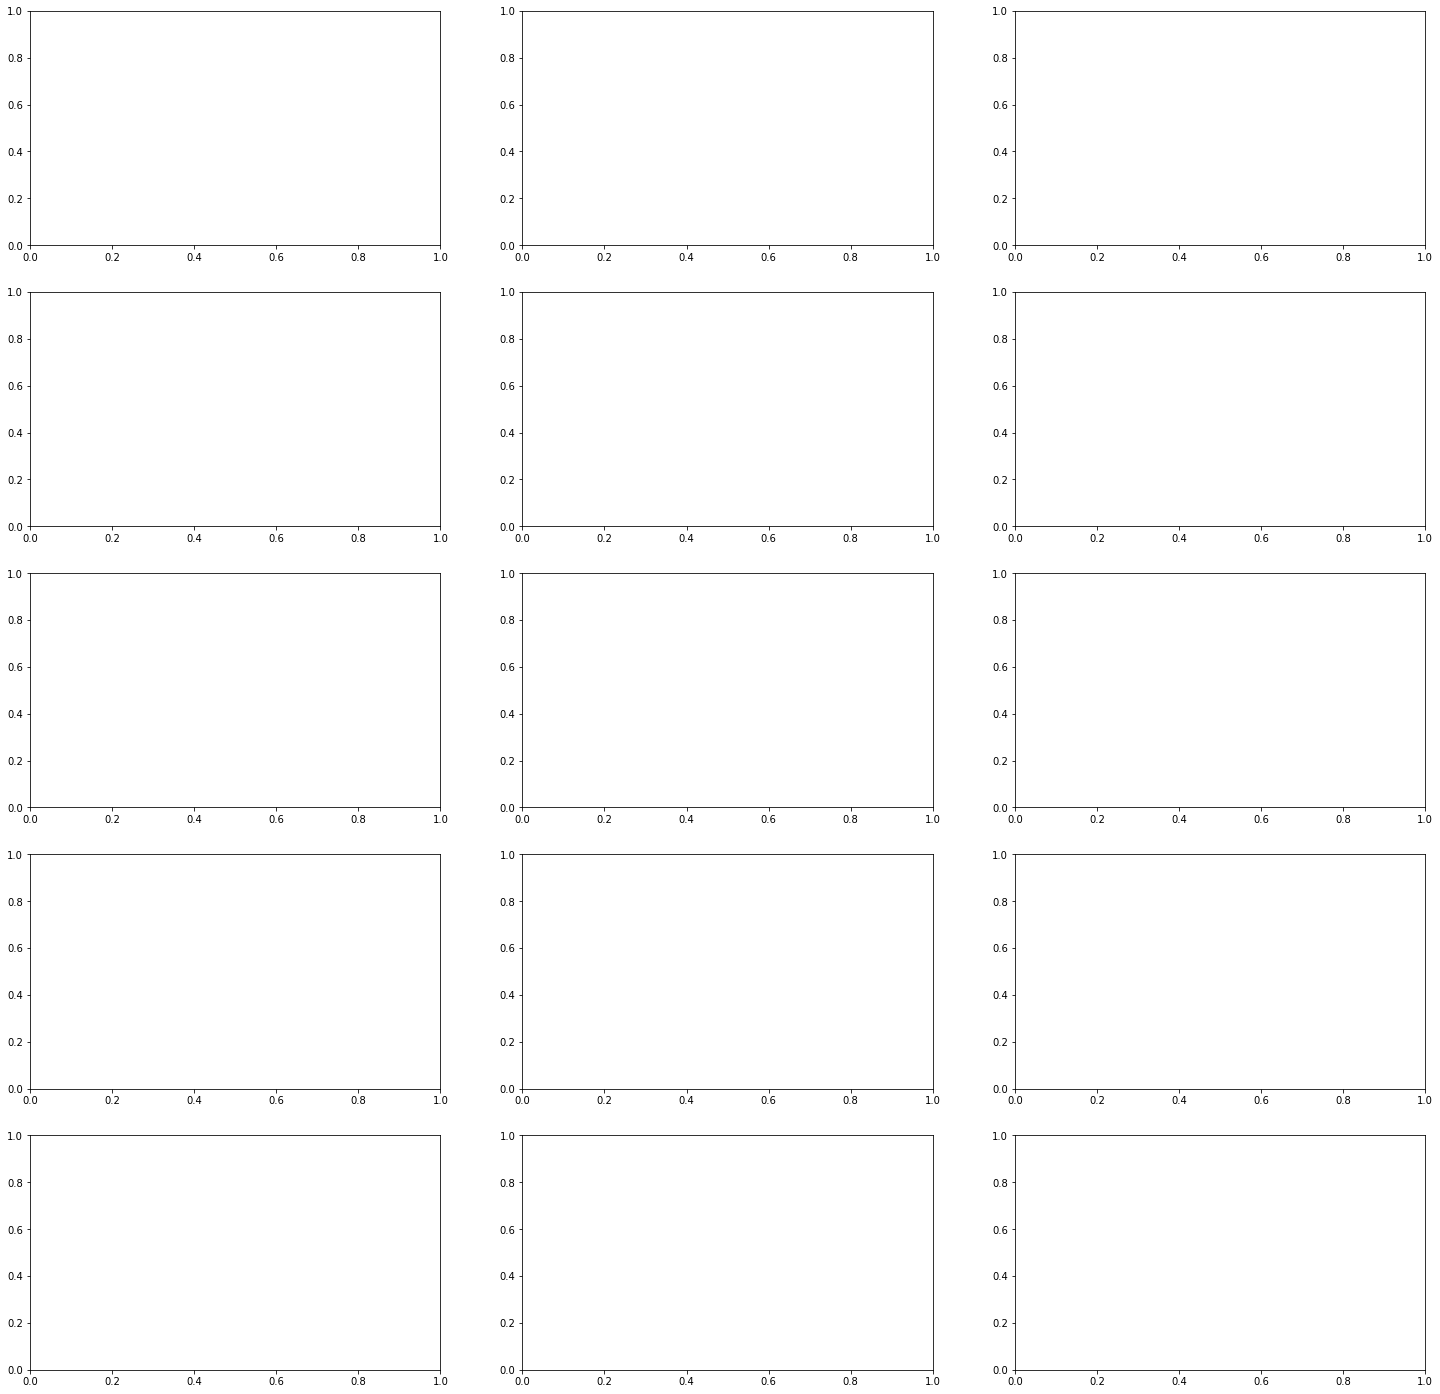

In [0]:
fig,ax = plt.subplots(5,3,figsize=[25,25])

for idx in range(5,10):
    ax[idx, 0].imshow(te_data[idx])
    ax[idx, 1].imshow(np.squeeze(te_mask[idx]), cmap = 'gray')
    ax[idx, 2].imshow(np.squeeze(predictions[idx]), cmap = 'gray')

### Counting

In [0]:
def line_scan_count(maska):
    h,w=maska.shape
    totalklas = 0
    oldlinecount = 0
    for y in range(0, h):
        oldc = 0
        linecount = 0
        start = 0   
        for x in range(0, w):
            c = maska[y,x] < 128;
            if c == 1 and oldc == 0:
                start = x
            if c == 0 and oldc == 1 and (x - start) > 10:
                linecount += 1
            oldc = c
        if oldlinecount != linecount:
            if linecount < oldlinecount:
                totalklas += oldlinecount - linecount
            oldlinecount = linecount
    return totalklas

In [0]:
os.chdir("C:\\Users\\Hunor\\Desktop\\University\\Semester 3\\Introduction to Image Processing\\Projekat\\all_mask")

In [0]:
df = pd.read_excel('Tim_No_4_Manual_Count.xlsx','Sheet1')
df.head()

In [0]:
def python_count():
    for i in range(62):
        df.iloc[i,2]=line_scan_count(lista[i])

In [0]:
df["average"]=np.nan
df["error"]=np.nan

In [0]:
for i in range(62):
        df.iloc[i,3]=line_scan_count(np.transpose(lista[i]))
        df.iloc[i,4]=(df.iloc[i,2]+df.iloc[i,3])/2
        df.iloc[i,5]=abs(df.iloc[i,1]-df.iloc[i,2])

In [0]:
for i in range(62):
        df.iloc[i,5]=abs(df.iloc[i,1]-df.iloc[i,4])